## Research Question: Which Features Are Most Predictive of Heart Disease?

In [2]:
# Import necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load dataset
heart_data = pd.read_csv(r"C:\Users\khate\OneDrive - McMaster University\Desktop\heart.csv")
heart_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [164]:
# calculate prevalance rate to understand dataset distribution 

prevalence_rate = heart_data['HeartDisease'].mean() * 100

print(f"Actual Prevalence in Dataset: {prevalence_rate:.2f}%")

if prevalence_rate >= 65:
    print("🔴 Your dataset is dominated by high-prevalence sources (Long Beach & Switzerland). Consider rebalancing.")
elif prevalence_rate <= 35:
    print("🔵 Your dataset is mostly from low-prevalence sources (Hungarian & Cleveland).")
elif 50 <= prevalence_rate <= 60:
    print("✅ Your dataset has a balanced mix of different locations.")
else:
    print("⚠️ Prevalence distribution is unclear; verify dataset composition.")

# Check if prevalence is extremely imbalanced
if prevalence_rate > 65 or prevalence_rate < 35:
    print("⚠️ Consider rebalancing the dataset to avoid training bias.")
else:
    print("✅ No major imbalance detected. Proceed with modeling!")

Actual Prevalence in Dataset: 55.34%
✅ Your dataset has a balanced mix of different locations.
✅ No major imbalance detected. Proceed with modeling!


In [4]:
# 2nd method to check the distribution of heart disease target variable in the dataset
heart_data['HeartDisease'].value_counts() 

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [5]:
# Define features and target variable
X = heart_data[['Age', 'Cholesterol', 'FastingBS', 'MaxHR', 'Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope']] # features or variables
Y = heart_data['HeartDisease'] # target variable

In [7]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=123)

In [8]:
# Separate numerical and categorical features
numercial_columns = ['Age', 'Cholesterol', 'FastingBS', 'MaxHR'] # numercial features
categorical_columns = ['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope'] # categorical features

In [10]:
# NOTE - Regression Model will be used. Therefore, it is important to handle missing values propoerly. 

# Create numeric pipeline

pipe_numeric = Pipeline([
('imputer', SimpleImputer(strategy='mean')), # replace missing values with mean
('scaler', StandardScaler()), #scale and normalize
('power', PowerTransformer(method='yeo-johnson')) #normalize skewed features
])

# Create categorical pipeline
pipe_categorical = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')), # replace missing values with most frequent
('onehot', OneHotEncoder(handle_unknown='ignore')) # convert categories to numbers
])

# Combine & preprocessing both pipelines
c_transformer = ColumnTransformer([
('numeric_mean', pipe_numeric, numercial_columns), 
('onehot_categorical', pipe_categorical, categorical_columns)
])

In [12]:
# Model pipeline with preprocessing + classifier
regression_pipeline = Pipeline([
('preprocessing', c_transformer),
('classifier', LogisticRegression())
])
regression_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_mean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['Age', 'Cholesterol',
                                                   'FastingBS', 'MaxHR']),
                                                 ('onehot_categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('classifier', LogisticRegression())])

In [13]:
# Define hyperparamter for tuning
param_grid = {
    'classifier__solver': ['lbfgs', 'liblinear', 'saga'],  # Best solvers for binary classification
    'classifier__penalty': ['l1', 'l2'],  # Regularization types
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength (lower = stronger penalty)
}

# Define scoring metrics
scoring_metrics = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'ROC_AUC': 'roc_auc'
}

# Create grid search, 5 folds, using hyperparameters, and multiple scoring metrics 

grid_search_pipeline = GridSearchCV(
estimator=regression_pipeline, # full pipeline
param_grid=param_grid, 
cv = 5, # 5 folds
scoring=scoring_metrics, 
refit='ROC_AUC', # best model based on best score
n_jobs=-1 # faster computation 
)

In [14]:
# Train the model 
grid_search_pipeline.fit(X_train,Y_train)

d:\DSI\envs\dsi_participant\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\DSI\envs\dsi_participant\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\DSI\envs\dsi_participant\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\DSI\envs\dsi_participant\lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric_mean',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('power',
                                                                                          PowerTransformer())]),
                                                                         ['Age',
                                                                          'Cholesterol',
                                                                          'FastingBS',
                                                                          'MaxHR']),
                                                                        ('onehot_categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one...
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope'])])),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['lbfgs', 'liblinear', 'saga']},
             refit='ROC_AUC',
             scoring={'Accuracy': 'accuracy', 'Precision': 'precision',
                      'ROC_AUC': 'roc_auc', 'Recall': 'recall'})

In [15]:
# Print best parameters
print(grid_search_pipeline.best_params_) # Outline best params for model

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [16]:
# Identify best model using best hyperparameters and make predictions
best_model = grid_search_pipeline.best_estimator_  # find best model based on best parameters
best_predictions = best_model.predict(X_test) # Predict using the best model 
print(classification_report(Y_test, best_predictions))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82        81
           1       0.83      0.91      0.87       103

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



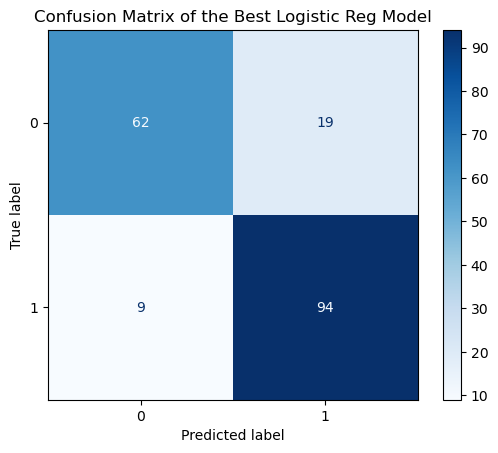

In [17]:
# Create a confusion matrix
cm = confusion_matrix(Y_test, best_predictions)

# display the confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix of the Best Logistic Reg Model')
plt.show()

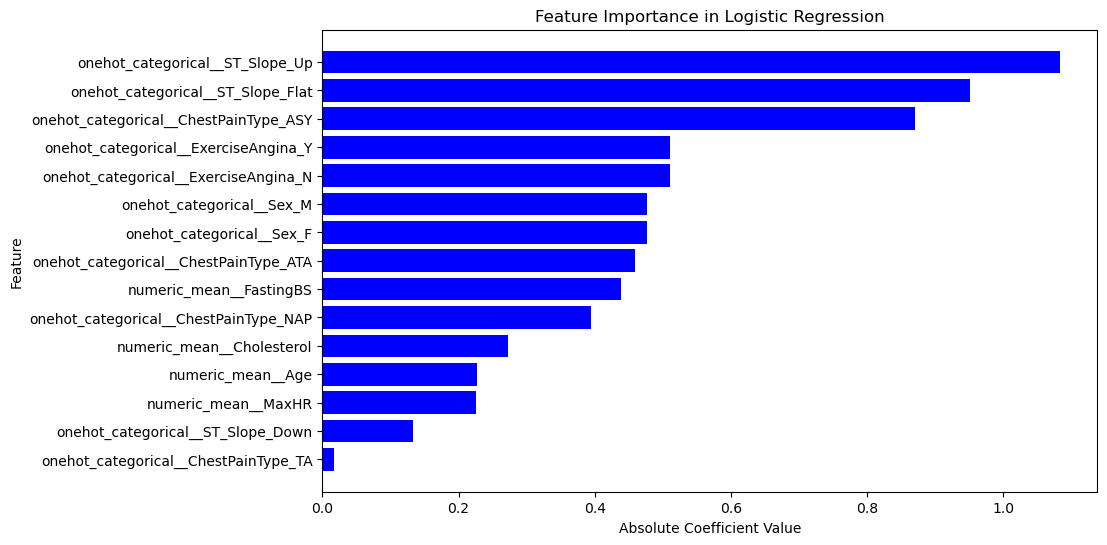

In [18]:
# Get feature names after ColumnTransformer
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

# Get model coefficients
coefficients = best_model.named_steps['classifier'].coef_[0]

# Ensure both arrays have the same length
assert len(feature_names) == len(coefficients), "Mismatch: feature names and coefficients"

# Create DataFrame for feature importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})

# Sort by absolute importance
feature_importance['Abs_Importance'] = np.abs(feature_importance['Importance'])
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Abs_Importance'], color='blue')
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance in Logistic Regression")
plt.gca().invert_yaxis()
plt.show()


In [22]:
import pickle

with open ('best_logistic_regression_model.pk1', 'wb') as best_regression_model:
    pickle.dump('best_model', best_regression_model)